In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =2e-20

nband = 120

ng =7

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 980

data w_diffuse
     &     /1.6 , 1.75 , 1.55 , 1.66,
     &     1.7 , 1.75 , 1.8/

data wgt
     &     /0.35 , 0.6 , 0.5 , 0.55,
     &     0.7 , 0.9 , 1.0/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

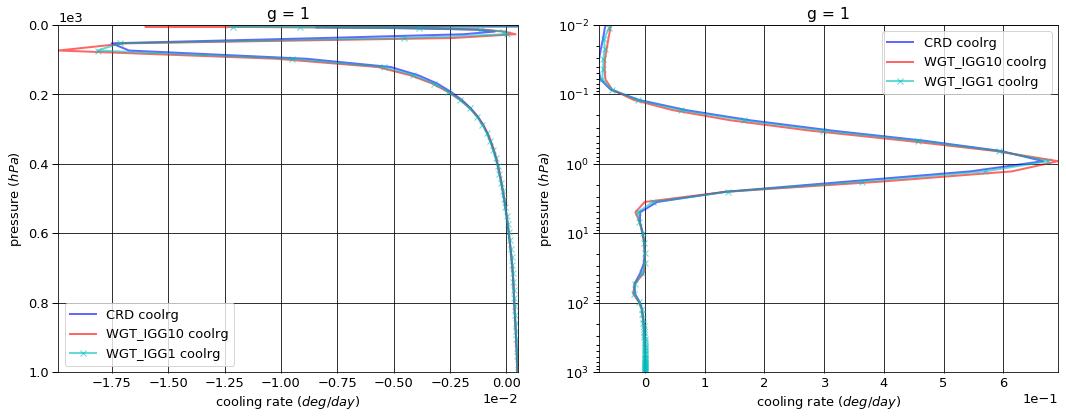

# Figure: cooling rate g-group 2

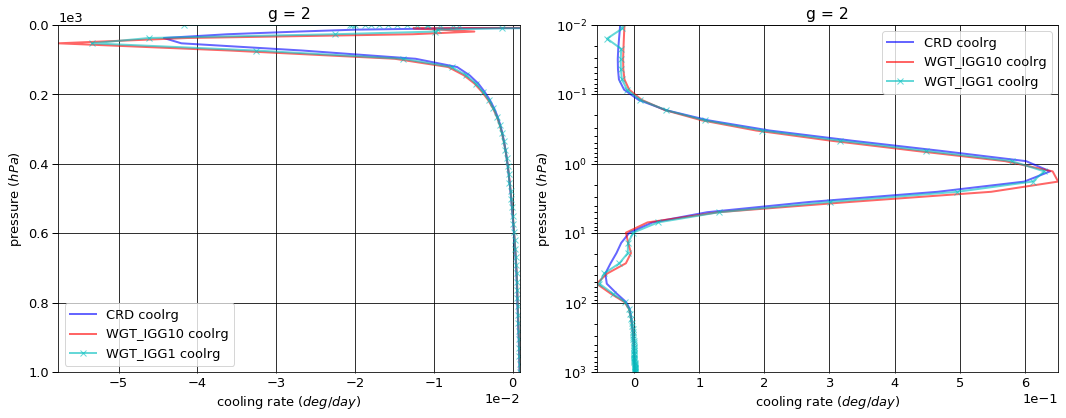

# Figure: cooling rate g-group 3

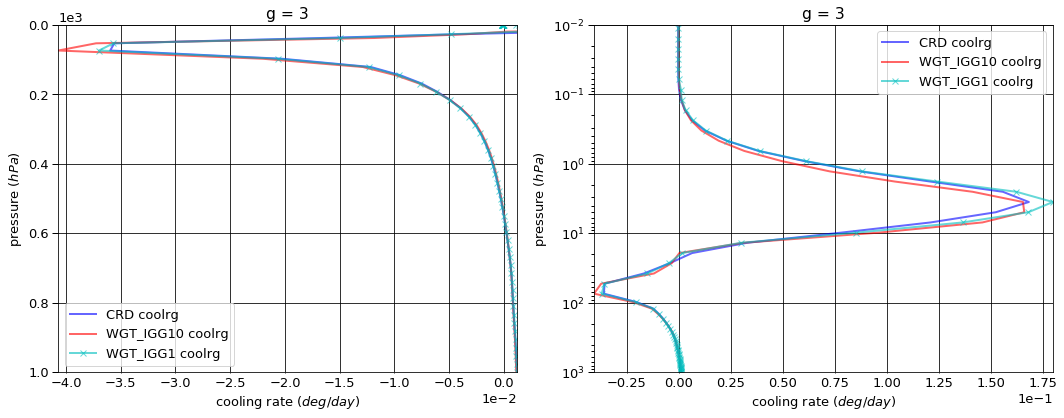

# Figure: cooling rate g-group 4

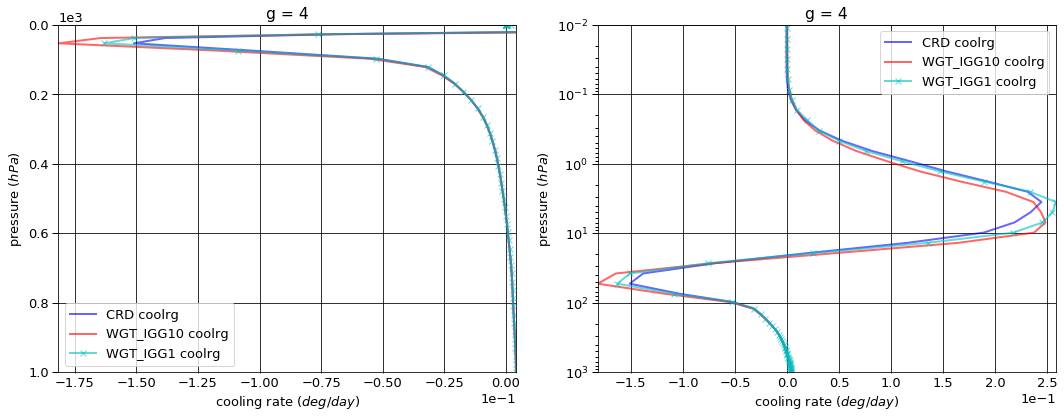

# Figure: cooling rate g-group 5

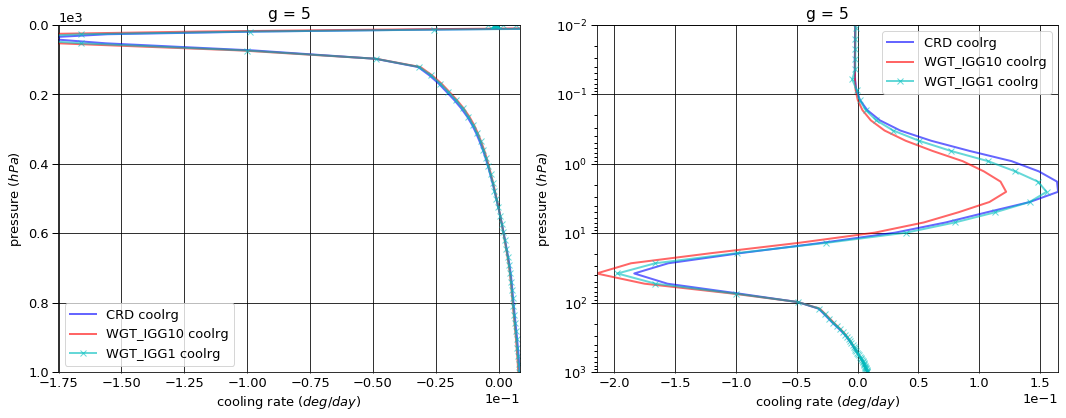

# Figure: cooling rate g-group 6

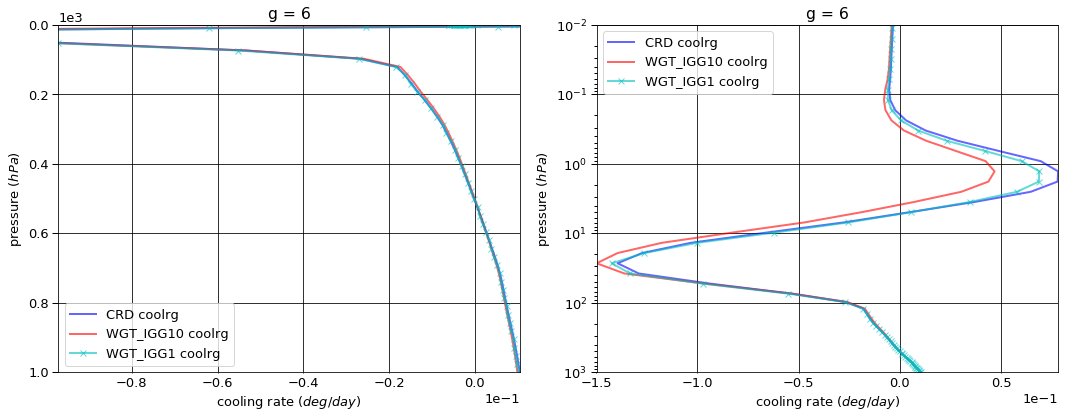

# Figure: cooling rate g-group 7

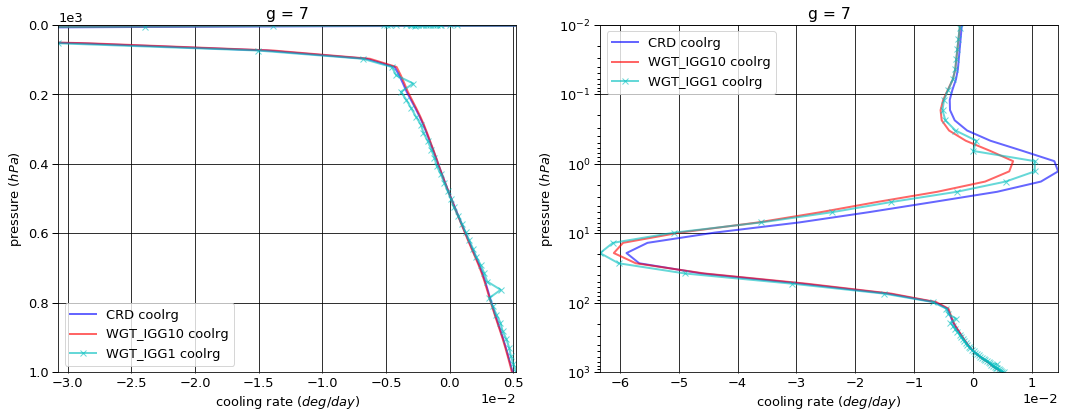

# Figure: cooling rate g-group total

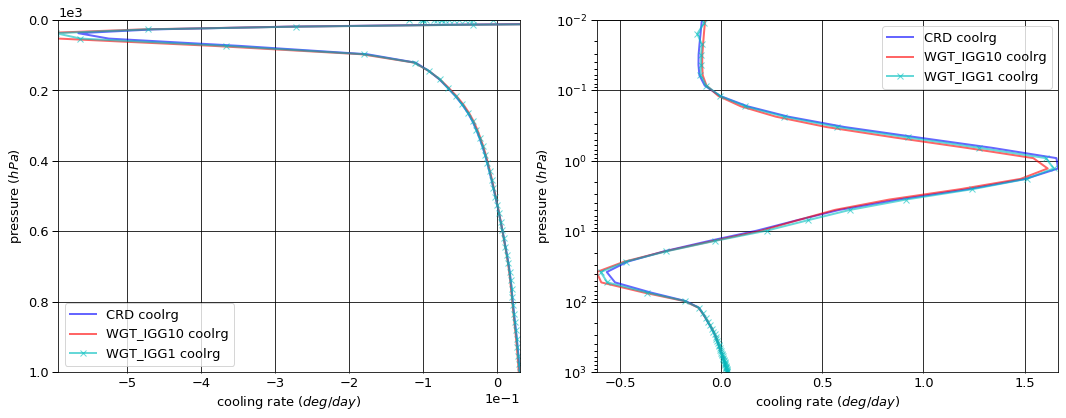

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.112728  0.000000  -0.112728
  1013.0   76     -0.243523  0.071353  -0.172170
2 0.0      1      -0.223211  0.000000  -0.223211
  1013.0   76     -0.539528  0.143065  -0.396463
3 0.0      1      -0.162992  0.000000  -0.162992
  1013.0   76     -0.551525  0.170989  -0.380536
4 0.0      1      -0.634748  0.000000  -0.634748
  1013.0   76     -2.288328  0.633076  -1.655252
5 0.0      1      -2.408281  0.000000  -2.408281
  1013.0   76     -4.923679  1.086183  -3.837496
6 0.0      1      -6.187982  0.000000  -6.187982
  1013.0   76     -8.176602  1.067508  -7.109094
7 0.0      1     -17.311275  0.000000 -17.311275
  1013.0   76    -18.005457  0.416632 -17.588824


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.116104  0.000000  -0.116104
  1013.0   76     -0.243523  0.067672  -0.175852
2 0.0      1      -0.227583  0.000000  -0.227583
  1013.0   76     -0.539528  0.134898  -0.404630
3 0.0      1      -0.164734  0.000000  -0.164734
  1013.0   76     -0.551525  0.159571  -0.391954
4 0.0      1      -0.564694  0.000000  -0.564694
  1013.0   76     -2.288328  0.610435  -1.677894
5 0.0      1      -2.268825  0.000000  -2.268825
  1013.0   76     -4.923679  1.044280  -3.879399
6 0.0      1      -6.167014  0.000000  -6.167014
  1013.0   76     -8.176602  1.022931  -7.153671
7 0.0      1     -17.310070  0.000000 -17.310070
  1013.0   76    -18.005457  0.407700 -17.597757


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.114178  0.000000  -0.114178
  1013.0   76     -0.243523  0.071678  -0.171846
2 0.0      1      -0.223270  0.000000  -0.223270
  1013.0   76     -0.539528  0.138757  -0.400771
3 0.0      1      -0.166829  0.000000  -0.166829
  1013.0   76     -0.551525  0.171340  -0.380185
4 0.0      1      -0.607621  0.000000  -0.607621
  1013.0   76     -2.288328  0.633117  -1.655212
5 0.0      1      -2.383867  0.000000  -2.383867
  1013.0   76     -4.923679  1.058080  -3.865600
6 0.0      1      -6.172828  0.000000  -6.172828
  1013.0   76     -8.176602  1.052025  -7.124576
7 0.0      1     -17.262925  0.000000 -17.262925
  1013.0   76    -18.005457  0.437930 -17.567526


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.003376  0.000000 -0.003376
  1013.0   76     0.000000 -0.003682 -0.003682
2 0.0      1     -0.004372  0.000000 -0.004372
  1013.0   76     0.000000 -0.008167 -0.008167
3 0.0      1     -0.001742  0.000000 -0.001742
  1013.0   76     0.000000 -0.011418 -0.011418
4 0.0      1      0.070054  0.000000  0.070054
  1013.0   76     0.000000 -0.022642 -0.022642
5 0.0      1      0.139456  0.000000  0.139456
  1013.0   76     0.000000 -0.041903 -0.041903
6 0.0      1      0.020968  0.000000  0.020968
  1013.0   76     0.000000 -0.044577 -0.044577
7 0.0      1      0.001205  0.000000  0.001205
  1013.0   76     0.000000 -0.008933 -0.008933


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001450  0.000000 -0.001450
  1013.0   76     0.000000  0.000325  0.000325
2 0.0      1     -0.000060  0.000000 -0.000060
  1013.0   76     0.000000 -0.004308 -0.004308
3 0.0      1     -0.003837  0.000000 -0.003837
  1013.0   76     0.000000  0.000351  0.000351
4 0.0      1      0.027127  0.000000  0.027127
  1013.0   76     0.000000  0.000041  0.000041
5 0.0      1      0.024413  0.000000  0.024413
  1013.0   76     0.000000 -0.028103 -0.028103
6 0.0      1      0.015155  0.000000  0.015155
  1013.0   76     0.000000 -0.015483 -0.015482
7 0.0      1      0.048350  0.000000  0.048350
  1013.0   76     0.000000  0.021298  0.021298

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.025710
  1001.112500 75     0.000495
2 0.000312    1     -0.008141
  1001.112500 75     0.000892
3 0.000312    1     -0.000096
  1001.112500 75     0.001194
4 0.000312    1     -0.000282
  1001.112500 75     0.004290
5 0.000312    1     -0.000893
  1001.112500 75     0.008398
6 0.000312    1     -0.001108
  1001.112500 75     0.010501
7 0.000312    1     -0.000598
  1001.112500 75     0.004930


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.021361
  1001.112500 75     0.000479
2 0.000312    1     -0.005765
  1001.112500 75     0.000918
3 0.000312    1     -0.000033
  1001.112500 75     0.001124
4 0.000312    1     -0.000018
  1001.112500 75     0.004110
5 0.000312    1     -0.000643
  1001.112500 75     0.007783
6 0.000312    1     -0.001279
  1001.112500 75     0.009943
7 0.000312    1     -0.000689
  1001.112500 75     0.004879


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.023090
  1001.112500 75     0.000505
2 0.000312    1     -0.006767
  1001.112500 75     0.000920
3 0.000312    1     -0.000065
  1001.112500 75     0.001212
4 0.000312    1     -0.000095
  1001.112500 75     0.004285
5 0.000312    1     -0.000610
  1001.112500 75     0.008061
6 0.000312    1     -0.001177
  1001.112500 75     0.010304
7 0.000312    1     -0.000698
  1001.112500 75     0.005227


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.004350
  1001.112500 75    -0.000016
2 0.000312    1      0.002376
  1001.112500 75     0.000027
3 0.000312    1      0.000063
  1001.112500 75    -0.000070
4 0.000312    1      0.000264
  1001.112500 75    -0.000180
5 0.000312    1      0.000251
  1001.112500 75    -0.000615
6 0.000312    1     -0.000171
  1001.112500 75    -0.000558
7 0.000312    1     -0.000091
  1001.112500 75    -0.000051


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.002620
  1001.112500 75     0.000010
2 0.000312    1      0.001373
  1001.112500 75     0.000029
3 0.000312    1      0.000031
  1001.112500 75     0.000018
4 0.000312    1      0.000187
  1001.112500 75    -0.000005
5 0.000312    1      0.000284
  1001.112500 75    -0.000337
6 0.000312    1     -0.000069
  1001.112500 75    -0.000196
7 0.000312    1     -0.000100
  1001.112500 75     0.000296

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.041216,0.000000,-27.041216
1013.0,76,-34.728642,3.588806,-31.139835



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.819023,0.000000,-26.819023
1013.0,76,-34.728642,3.447486,-31.281156



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.931518,0.000000,-26.931518
1013.0,76,-34.728642,3.562926,-31.165715



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.222193,0.000000,0.222193
1013.0,76,0.000000,-0.141321,-0.141321



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.109698,0.00000,0.109698
1013.0,76,0.000000,-0.02588,-0.025880


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.036828
1001.112500,75,0.030699



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.029787
1001.112500,75,0.029235



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.032502
1001.112500,75,0.030514



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.007041
1001.112500,75,-0.001464



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.004326
1001.112500,75,-0.000185


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007008,0.007001
2,0.015458,0.015548
3,0.015917,0.015833
4,0.065800,0.065818
5,0.140908,0.141961
6,0.232192,0.236740
7,0.522717,0.517099


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.107750e-18
2,7.729691e-19
3,1.023108e-18
4,2.756166e-19
5,7.424874e-20
6,2.000197e-20
7,1.116904e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.107750e-18,NaN,0.007008,0.007001,0.007008,0.007001,1.0
2,7.729691e-19,0.151333,0.015458,0.015548,0.022467,0.022549,1.0
3,1.023108e-18,1.323608,0.015917,0.015833,0.038383,0.038382,50.0
4,2.756166e-19,0.269391,0.065800,0.065818,0.104183,0.104200,50.0
5,7.424874e-20,0.269391,0.140908,0.141961,0.245092,0.246161,50.0
6,2.000197e-20,0.269391,0.232192,0.236740,0.477283,0.482901,50.0
7,1.116904e-22,0.005584,0.522717,0.517099,1.000000,1.000000,50.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     1.254270e-17  9.587700e-18   1.308207  1.691648e-05
      2 0.000312     1.787034e-18  1.183577e-18   1.509858  2.461599e-06
      3 0.000312     2.983819e-20  2.786805e-20   1.070695  4.595139e-08
      4 0.000312     2.618279e-20  1.875552e-20   1.396004  3.637574e-08
      5 0.000312     1.932990e-20  8.386681e-21   2.304832  2.555629e-08
      6 0.000312     8.604753e-21  3.392565e-21   2.536356  1.287381e-08
      7 0.000312     1.363137e-21  5.068078e-23  26.896536  2.170928e-09
2     1 0.000750     1.253215e-17  9.587754e-18   1.307099  7.713649e-06
      2 0.000750     1.789768e-18  1.186167e-18   1.508866  1.124781e-06
      3 0.000750     3.004541e-20  2.805813e-20   1.070828  2.110463e-08
      4 0.000750     2.630346e-20  1.882967e-20   1.396915  1.666493e-08
      5 0.000750     1.941035e-20  8.408953e-21   2.308295  1.170304e-08
      6 0.000750     8.639271e-21  3.401869e-21   2.539566  5.895520e-09
      7 0.000750     1.367492e-21  5.085838e-23  26.888227  9.934131e-10
3     1 0.001052     1.251124e-17  9.587923e-18   1.304895  1.334387e-05
      2 0.001052     1.795242e-18  1.191310e-18   1.506948  1.953803e-06
      3 0.001052     3.039147e-20  2.837218e-20   1.071172  3.694885e-08
      4 0.001052     2.653398e-20  1.896642e-20   1.398997  2.908514e-08
      5 0.001052     1.957226e-20  8.451812e-21   2.315747  2.041760e-08
      6 0.001052     8.709407e-21  3.420185e-21   2.546472  1.028730e-08
      7 0.001052     1.376370e-21  5.116352e-23  26.901393  1.730842e-09
4     1 0.001476     1.248989e-17  9.587895e-18   1.302673  2.227896e-05
      2 0.001476     1.800796e-18  1.196543e-18   1.504999  3.275776e-06
      3 0.001476     3.075964e-20  2.870705e-20   1.071501  6.247201e-08
      4 0.001476     2.677222e-20  1.910829e-20   1.401078  4.900433e-08
      5 0.001476     1.973796e-20  8.495837e-21   2.323251  3.438479e-08
      6 0.001476     8.781275e-21  3.438931e-21   2.553489  1.732766e-08
      7 0.001476     1.385505e-21  5.148571e-23  26.910482  2.911051e-09
5     1 0.002070     1.246836e-17  9.587650e-18   1.300461  3.626034e-05
      2 0.002070     1.806359e-18  1.201805e-18   1.503039  5.354019e-06
      3 0.002070     3.115190e-20  2.906500e-20   1.071801  1.030344e-07
      4 0.002070     2.701638e-20  1.925464e-20   1.403110  8.050036e-08
      5 0.002070     1.990542e-20  8.540653e-21   2.330666  5.645109e-08
      6 0.002070     8.853947e-21  3.457911e-21   2.560490  2.845260e-08
      7 0.002070     1.394781e-21  5.182603e-23  26.912755  4.773096e-09
6     1 0.002904     1.244659e-17  9.587165e-18   1.298256  5.792252e-05
      2 0.002904     1.811935e-18  1.207104e-18   1.501059  8.588856e-06
      3 0.002904     3.157679e-20  2.945434e-20   1.072059  1.669384e-07
      4 0.002904     2.726816e-20  1.940704e-20   1.405065  1.298209e-07
      5 0.002904     2.007479e-20  8.586527e-21   2.337941  9.096684e-08
      6 0.002904     8.927442e-21  3.477187e-21   2.567432  4.585685e-08
      7 0.002904     1.404201e-21  5.219122e-23  26.904933  7.681823e-09
7     1 0.004074     1.242451e-17  9.586410e-18   1.296055  9.119212e-05
      2 0.004074     1.817532e-18  1.212458e-18   1.499048  1.358005e-05
      3 0.004074     3.204638e-20  2.988684e-20   1.072257  2.669167e-07
      4 0.004074     2.752998e-20  1.956773e-20   1.406907  2.064109e-07
      5 0.004074     2.024639e-20  8.633845e-21   2.345003  1.444855e-07
      6 0.004074     9.001806e-21  3.496858e-21   2.574256  7.284608e-08
      7 0.004074     1.413771e-21  5.259080e-23  26.882487  1.218600e-08
8     1 0.005714     1.240199e-17  9.585342e-18   1.293850  1.419071e-04
      2 0.005714     1.823166e-18  1.217891e-18   1.496987  2.122405e-05
      3 0.005714     3.257781e-20  3.037912e-20   1.072375  4.225661e-07
      4 0.005714     2.780542e-20  1.973992e-20   1.408589  3.245372e-07
      5 0.0

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
